# Annual Sea Level Anomalies
Annual mean sea level anomalies. This page is very much in development!!

```{caution}
Major updates are needed for this page. Don't look at it too hard...
```


## Setup

As with previous sections, we first need to import the necessary libraries, establish our input/output directories, and set up some basic plotting rules. We'll do this by running another notebook called "setup" and "plotting functions," and then we'll set our data and output paths. If you have not run the datawrangling notebook, you will need to do this before running this notebook.

In [1]:
%run ../setup.ipynb
%run ../plotting_functions.ipynb
data_dir = Path('../../data' )
output_dir = Path('../../output') 

# check to make sure that data_dir/rsl_daily_hawaii.nc exists, if not, make warning to run datawrangling notebook
if not (data_dir / 'rsl_daily_hawaii.nc').exists():
    print('rsl_daily_hawaii.nc not found in ../../data. Please run the data wrangling notebook first')
else:
    print('rsl_daily_hawaii.nc found in ../../data. Proceed.')



rsl_daily_hawaii.nc found in ../../data. Proceed.


### Import the tide gauge data

In [2]:
#import rsl_daily
rsl_daily = xr.open_dataset(data_dir/ 'rsl_daily_hawaii.nc')

#make rsl_daily a subset - do not include TGs with more than 25% NaNs
# get percent Nans in rsl_daily['sea_level']

rsl_daily

<xarray.Dataset>
Dimensions:       (record_id: 11, time: 10957)
Coordinates:
  * record_id     (record_id) int16 140 500 520 570 580 ... 610 5470 5480 5520
  * time          (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2022-12-31
    lat           (record_id) float32 ...
    lon           (record_id) float32 ...
    station_name  (record_id) <U17 ...
    storm_year    (time) int64 ...
Data variables:
    rsl_anomaly   (record_id, time) float32 ...
    rsl_mhhw      (record_id, time) float64 ...
Attributes:
    long_name:  Sea Level Anomaly
    units:      m
    source:     in situ tide gauge water level observations
    platform:   station_name, station_country, station_country_code, uhslc_id...
    epoch:      1993-2001

### check the data and drop all stations with less than 80% coverage

In [3]:
data_coverage = rsl_daily.rsl_mhhw.count(dim='time')/len(rsl_daily.time)

#drop all locations with data_coverage less than 80%
rsl_subset = rsl_daily.where(data_coverage>0.80,drop=True)

rsl_subset

<xarray.Dataset>
Dimensions:       (record_id: 8, time: 10957)
Coordinates:
  * record_id     (record_id) int16 500 520 570 580 590 600 610 5520
  * time          (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2022-12-31
    lat           (record_id) float32 28.22 16.75 21.31 ... 19.73 21.43 20.03
    lon           (record_id) float32 182.6 190.5 202.1 ... 204.9 202.2 204.2
    station_name  (record_id) <U17 'Midway' 'Johnston' ... 'Mokuoloe' 'Kawaihae'
    storm_year    (time) int64 ...
Data variables:
    rsl_anomaly   (record_id, time) float32 -0.05425 -0.022 ... -0.1367
    rsl_mhhw      (record_id, time) float64 -0.2078 -0.1756 ... -0.3183 -0.446
Attributes:
    long_name:  Sea Level Anomaly
    units:      m
    source:     in situ tide gauge water level observations
    platform:   station_name, station_country, station_country_code, uhslc_id...
    epoch:      1993-2001

In [4]:
# Group by storm_year and record_id
rsl_yearly_mean = rsl_subset.groupby('storm_year').mean('time')
rsl_yearly_mean

<xarray.Dataset>
Dimensions:       (storm_year: 31, record_id: 8)
Coordinates:
  * record_id     (record_id) int16 500 520 570 580 590 600 610 5520
    lat           (record_id) float32 28.22 16.75 21.31 ... 19.73 21.43 20.03
    lon           (record_id) float32 182.6 190.5 202.1 ... 204.9 202.2 204.2
    station_name  (record_id) <U17 'Midway' 'Johnston' ... 'Mokuoloe' 'Kawaihae'
  * storm_year    (storm_year) int64 1992 1993 1994 1995 ... 2019 2020 2021 2022
Data variables:
    rsl_anomaly   (storm_year, record_id) float32 -0.05539 -0.07089 ... 0.01844
    rsl_mhhw      (storm_year, record_id) float64 -0.209 -0.3998 ... -0.2909
Attributes:
    long_name:  Sea Level Anomaly
    units:      m
    source:     in situ tide gauge water level observations
    platform:   station_name, station_country, station_country_code, uhslc_id...
    epoch:      1993-2001

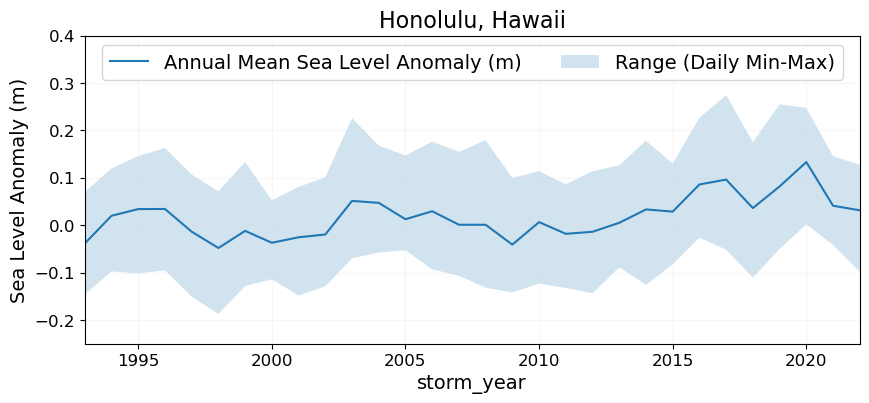

In [5]:

# get record_id of "Honolulu, Hawaii" station
rid = rsl_subset.station_name.str.contains('Honolulu, Hawaii').argmax()
rid

rsl_yearly_mean['rsl_anomaly'].isel(record_id=rid).plot(x='storm_year',label='Annual Mean Sea Level Anomaly (m)')

# get min and max for each month
rsl_yearly_min = rsl_subset.groupby('storm_year').min('time')
rsl_yearly_max = rsl_subset.groupby('storm_year').max('time')

#make a fill from max to min for each month
plt.fill_between(rsl_yearly_min.storm_year, 
                 rsl_yearly_min['rsl_anomaly'].isel(record_id=rid), 
                 rsl_yearly_max['rsl_anomaly'].isel(record_id=rid), 
                 alpha=0.2, label='Range (Daily Min-Max)')


plt.ylabel('Sea Level Anomaly (m)')

# remove the x-axis label
# plt.xlabel('')

# change the title to station name
plt.title(rsl_yearly_mean['station_name'].isel(record_id=rid).values)

# Adjust x-axis limits and add a grid
plt.xlim(1993,2022)
plt.ylim(-0.25, 0.4)
plt.grid(alpha=0.2, color='lightgray')

# Add a legend at the top in 3 columns
plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1))

# Save the plot to a file
plt.savefig(output_dir / 'SL_YMA_annual.png', dpi=300, bbox_inches='tight')

fig = plt.gcf()

glue("SL_YMA_annual",fig,display=False)

#add El Nino and La Nina years

# # add ENSO to the plots
# # import oni.csv
# oni = pd.read_csv(data_dir/'oni.csv',header=0)
# # change oni index to Date column
# oni.index = pd.to_datetime(oni['Date'] )

# #adjust the index to be float value of fractional year
# oni.index = oni.index.year + (oni.index.month - 1)/12

# ymin, ymax = plt.ylim()

# # Shading El Niño events
# plt.fill_between(oni.index, ymin,ymax, 
#                 where=oni['El Nino'] == 1, color='red', alpha=0.2, label='El Niño')
# # Shading La Niña events
# plt.fill_between(oni.index,  ymin,ymax,
#                 where=oni['La Nina'] == 1, color='blue', alpha=0.2, label='La Niña')


```{glue:figure} SL_YMA_annual
:name: "SL_YMA_annual"

Yearly mean anomalies at the Honolulu tide gauge . Note that the sea level is plotted in units of m, relative to the epoch mean (1983-2001).
```

In [6]:
oni

NameError: name 'oni' is not defined

## Absolute Value: satellite (trend removed)

In [5]:
# open the cmems data
cmems = xr.open_dataset(data_dir / 'cmems_L4_SSH_0.25deg_1993_2023.nc')

In [6]:
def process_trend_with_nan(sea_level_anomaly):
    # Flatten the data and get a time index
    # first ensure time is the first dimension regardless of other dimensions
    sea_level_anomaly = sea_level_anomaly.transpose('time', ...)
    sla_flat = sea_level_anomaly.values.reshape(sea_level_anomaly.shape[0], -1)
    time_index = pd.to_datetime(sea_level_anomaly.time.values).to_julian_date()

    detrended_flat = np.full_like(sla_flat, fill_value=np.nan)

    # Loop over each grid point
    for i in range(sla_flat.shape[1]):
        # Get the time series for this grid point
        y = sla_flat[:,i]
        mask = ~np.isnan(y)

        if np.any(mask):
            time_masked = time_index[mask]
            y_masked = y[mask]

            slope, intercept, _, _, _ = stats.linregress(time_masked, y_masked)
            trend = slope * time_index + intercept

            detrended_flat[:,i] = y - trend

    detrended = detrended_flat.reshape(sea_level_anomaly.shape)

    # Calculate trend magnitude
    sea_level_trend = sea_level_anomaly - detrended
    trend_mag = sea_level_trend[-1] - sea_level_trend[0]

    times = pd.to_datetime(sea_level_anomaly['time'].values)
    time_mag = (times[-1] - times[0]).days/365.25 # in years

    trend_rate = trend_mag / time_mag

    return trend_mag, sea_level_trend, trend_rate  

### Plot an area-wide map, with stations
First we'll need to make sure that our data is detrended properly in order to look at yearly anomalies.

```{margin}
```{caution}
Come back and check this. Also note: need to add stations on here. #TODO
```
```

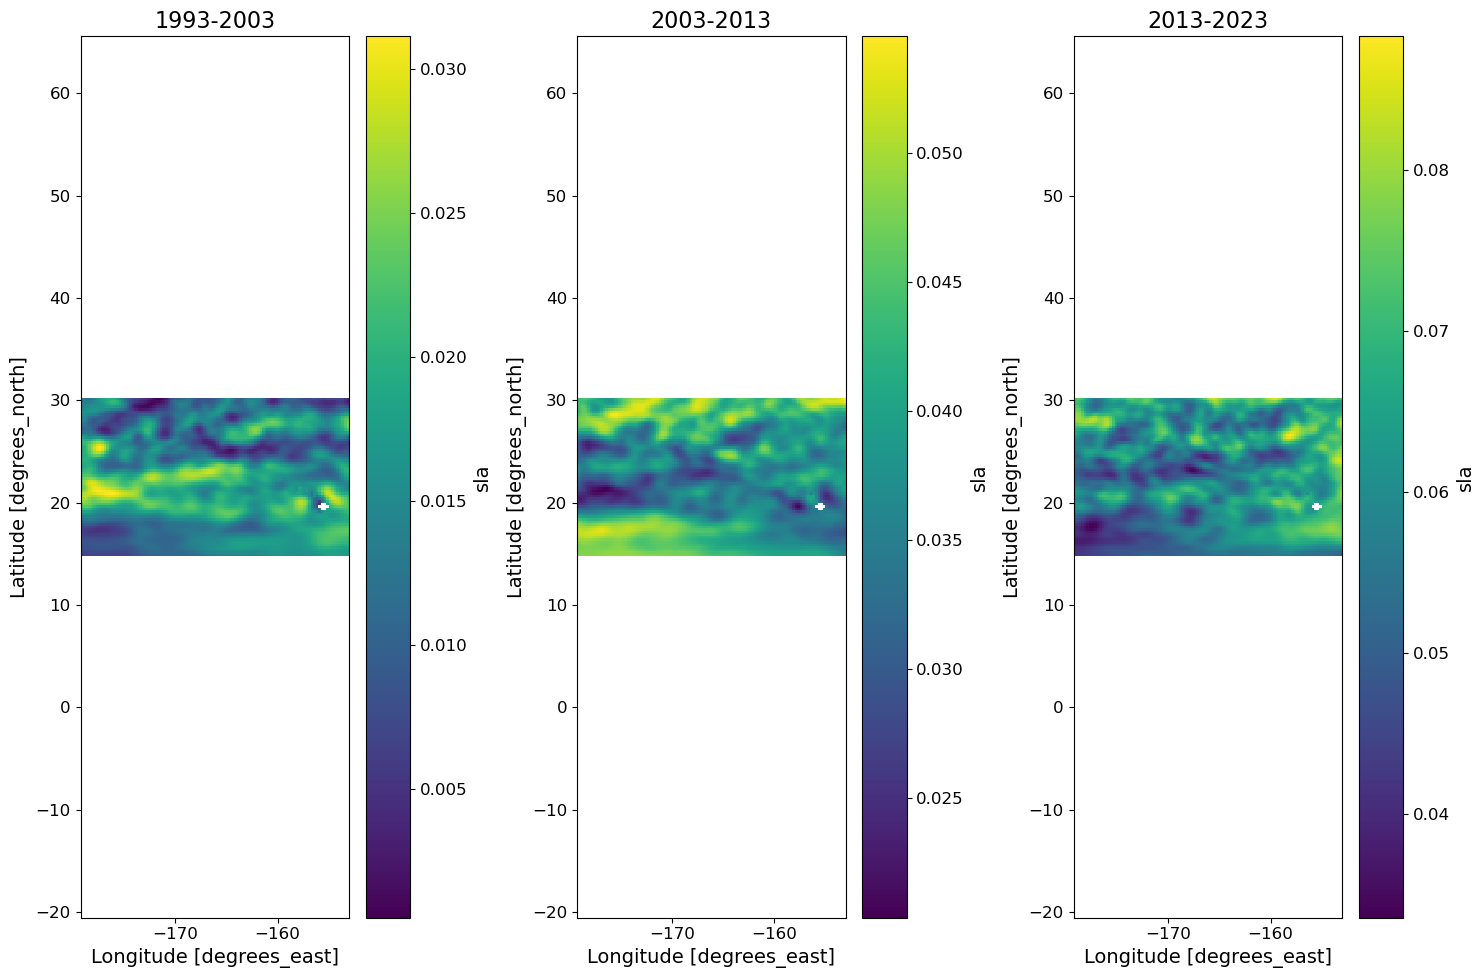

In [34]:
# concentrating on decadal trends
# let's look at 1993-2003 and 2003-2013
cmems1993_2003 = cmems.sel(time=slice('1993','2003'))
# # plot a map

# plot 3 slices of cmems.sla
fig, axs = plt.subplots(1,3, figsize=(15,10))

yr_start = [1993,2003,2013]
yr_stop = [2003,2013,2023]

# make 3 subplots for each year range


crs = ccrs.PlateCarree()
    fig, ax = plt.subplots(1,3,figsize=(10, 5), subplot_kw={'projection': crs})
 
# Loop through each period
for i, ax in enumerate(axs.flat):
    # Select the data for the current period and calculate the mean over time
    sla_mean = cmems.sel(time=slice(str(yr_start[i]), str(yr_stop[i]))).sla.mean(dim='time')
    
    # Plot the mean sea level anomaly
    c = sla_mean.plot(ax=ax)
    
    # Set the title to the current period
    ax.set_title(f'{yr_start[i]}-{yr_stop[i]}')
    # Set the aspect of the plot to 'equal' to maintain scaling on both axes
    ax.set_aspect('equal', adjustable='datalim')
    
    # Optionally, adjust color limits for consistency across plots
    c.set_clim(vmin=sla_mean.min(), vmax=sla_mean.max())

# Adjust layout to prevent overlap
plt.tight_layout()



```{glue:figure} mma_asl_fig
:name: "mma-asl-fig"
Map of absolute monthly mean sea level anomalies from altimetry for the full record from {glue:text}`station_group`, {glue:text}`country` station from {glue:text}`startDateTime` to {glue:text}`endDateTime`.
```


## Relative Value: tide station (trend removed)
### area-wide map with stations
### station plots: time series  
These should have ONI/ENSO phase included on them

In [8]:
def process_trend_with_nan(sea_level_anomaly):
    # Flatten the data and get a time index
    # first ensure time is the first dimension regardless of other dimensions
    sea_level_anomaly = sea_level_anomaly.transpose('time', ...)
    sla_flat = sea_level_anomaly.values.reshape(sea_level_anomaly.shape[0], -1)
    time_index = pd.to_datetime(sea_level_anomaly.time.values).to_julian_date()

    detrended_flat = np.full_like(sla_flat, fill_value=np.nan)

    # Loop over each grid point
    for i in range(sla_flat.shape[1]):
        # Get the time series for this grid point
        y = sla_flat[:,i]
        mask = ~np.isnan(y)

        if np.any(mask):
            time_masked = time_index[mask]
            y_masked = y[mask]

            slope, intercept, _, _, _ = stats.linregress(time_masked, y_masked)
            trend = slope * time_index + intercept

            detrended_flat[:,i] = y - trend

    detrended = detrended_flat.reshape(sea_level_anomaly.shape)

    # Calculate trend magnitude
    sea_level_trend = sea_level_anomaly - detrended
    trend_mag = sea_level_trend[-1] - sea_level_trend[0]

    times = pd.to_datetime(sea_level_anomaly['time'].values)
    time_mag = (times[-1] - times[0]).days/365.25 # in years

    trend_rate = trend_mag / time_mag

    return trend_mag, sea_level_trend, trend_rate  

In [9]:
# remove long-term trend from rsl_yearly
trend_mag_rsl, trend_line_rsl, trend_rate_rsl = process_trend_with_nan(rsl_yearly.sea_level)

rsl_yearly_detrended = rsl_yearly.sea_level - trend_line_rsl

# add detrended rsl_yearly to rsl_yearly
rsl_yearly['sea_level_detrended'] = rsl_yearly_detrended
rsl_yearly['sea_level_detrended'].attrs = {'long_name': 'sea level anomaly', 'units': 'm'}

In [10]:
# remove annual cycle from rsl_yearly
rsl_yearly_detrended = rsl_yearly_detrended.groupby('time.month') - rsl_yearly_detrended.groupby('time.month').mean(dim='time')

# add to rsl_yearly
rsl_yearly['sea_level_detrended_anom'] = rsl_yearly_detrended
rsl_yearly['sea_level_detrended_anom'].attrs = {'long_name': 'monthly mean sea level anomaly', 'units': 'm'}

## Make a plot